<pre>
1. Download the data from <a href='https://drive.google.com/file/d/15dCNcmKskcFVjs7R0ElQkR61Ex53uJpM/view?usp=sharing'>here</a>


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [2]:
callback_data = pd.read_csv('data.csv')
callback_data.head()

X = callback_data[['f1','f2']]
X.shape
y = callback_data['label']
# X.shape, y.shape

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)


In [3]:
y.value_counts()

1.0    10000
0.0    10000
Name: label, dtype: int64

In [4]:
!rm -rf logs/
X, y

(             f1        f2
 0      0.450564  1.074305
 1      0.085632  0.967682
 2      0.117326  0.971521
 3      0.982179 -0.380408
 4     -0.720352  0.955850
 ...         ...       ...
 19995 -0.491252 -0.561558
 19996 -0.813124  0.049423
 19997 -0.010594  0.138790
 19998  0.671827  0.804306
 19999 -0.854865 -0.588826
 
 [20000 rows x 2 columns], 0        0.0
 1        0.0
 2        1.0
 3        0.0
 4        0.0
         ... 
 19995    0.0
 19996    1.0
 19997    1.0
 19998    0.0
 19999    0.0
 Name: label, Length: 20000, dtype: float64)

In [5]:
np.random.rand(1)

array([0.75519819])

In [6]:
# X['f2'] = X['f2'] + np.random.rand(1)

In [7]:
X['f2'][:5]

0    1.074305
1    0.967682
2    0.971521
3   -0.380408
4    0.955850
Name: f2, dtype: float64

In [8]:
X['f2'][:5]

0    1.074305
1    0.967682
2    0.971521
3   -0.380408
4    0.955850
Name: f2, dtype: float64

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13400, 2), (6600, 2), (13400,), (6600,))

2. Code the model to classify data like below image

<img src='https://i.imgur.com/33ptOFy.png'>

In [10]:

from sklearn.metrics import f1_score, auc, roc_curve

class Calculate_micro_f1_score_and_auc(Callback):
    def __init__(self, validation_data):
        super(Callback, self).__init__()
        self.X_val, self.y_val = validation_data
    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        !rm -rf logs/
        self.history={'loss': [],'accuracy': [],'val_loss': [],'val_accuracy': [], 'f1_score': [], 'auc': []}
    # here how are we getting the values of epocs and logs we are not calling it explicitly ?
    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        
        #calculate f1_score
        y_hat = self.model.predict(self.X_val)
        get_f1_score = f1_score(np.array(self.y_val), y_hat, average='micro')
        self.history['f1_score'].append(get_f1_score)
        
        #calculate auc
        fpr, tpr, thresholds = roc_curve( np.array(self.y_val) , y_hat)
        get_auc = auc(fpr, tpr)
        self.history['auc'].append(get_auc)
        self.history['loss'].append(logs.get('loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
        
        #val loss and accuracy 
        if logs.get('val_loss', -1) != -1:
            self.history['val_loss'].append(logs.get('val_loss'))
        if logs.get('val_accuracy', -1) != -1:
            self.history['val_accuracy'].append(logs.get('val_accuracy'))
            
            
        #3. Write your own callback function, that has to print the micro F1 score and AUC score after each epoch.
        print("\nauc score is {}".format(get_auc))
        print("f1 score  is {}".format(get_f1_score))
        logs['f1_score'] = get_f1_score
        logs['auc']      = get_auc
        #print("\n")
        #print("history details: ", self.history)
        #print("\n")
        #print("logs:",logs)
        #print("\n")
        
        
        # ALl logics here only ???
      

            
f1_score_and_auc=Calculate_micro_f1_score_and_auc((X_test, y_test))            

4. Save your model at every epoch if your validation accuracy is improved from previous epoch.

In [11]:
import os
class save_your_model(Callback):
    def __init__(self, verbose=True):
        super(Callback, self).__init__()
        self.verbose = verbose
    def on_train_begin(self, logs={}):
        self.history={'loss': [],'accuracy': [],'val_loss': [],'val_accuracy': [], 'f1_score': [], 'auc': []}
        if not os.path.exists("model_save"):
            os.mkdir("model_save")
    def on_epoch_end(self, epochs, logs):
        self.history['loss'].append(logs.get('loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
        
        #val loss and accuracy 
        if logs.get('val_loss', -1) != -1:
            self.history['val_loss'].append(logs.get('val_loss'))
        if logs.get('val_accuracy', -1) != -1:
            self.history['val_accuracy'].append(logs.get('val_accuracy'))
        last_two_val_accuracy = self.history['val_accuracy'][-2:]
        if len(last_two_val_accuracy)==2:
            prev_epoch_val_accuracy, curr_epoch_val_accuracy = last_two_val_accuracy
            if curr_epoch_val_accuracy > prev_epoch_val_accuracy :
                filepath="model_save/weights-{}-{}.hdf5".format(epochs,logs.get('val_accuracy'))
                self.model.save(filepath)
                print("save the best model weights")

saveImprovedModel = save_your_model()

5. you have to decay learning based on below conditions 
        Cond1. If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
               learning rate by 10%. 
        Cond2. For every 3rd epoch, decay your learning rate by 5%.

In [12]:
from tensorflow.python.keras import backend as K
import os
class model_decay_learning_rate(Callback):
    def __init__(self, verbose=True):
        super(Callback, self).__init__()
        self.verbose = verbose
    def on_train_begin(self, logs={}):
        self.history={'loss': [],'accuracy': [],'val_loss': [],'val_accuracy': [], 'f1_score': [], 'auc': [], 'lr':[]}
    def on_epoch_end(self, epochs, logs):
        self.history['loss'].append(logs.get('loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
        
        #val loss and accuracy 
        if logs.get('val_loss', -1) != -1:
            self.history['val_loss'].append(logs.get('val_loss'))
        if logs.get('val_accuracy', -1) != -1:
            self.history['val_accuracy'].append(logs.get('val_accuracy'))
        last_two_val_accuracy = self.history['val_accuracy'][-2:]
        if len(last_two_val_accuracy)==2:
            prev_epoch_val_accuracy, curr_epoch_val_accuracy = last_two_val_accuracy
            if curr_epoch_val_accuracy > prev_epoch_val_accuracy :
                #get the cuurent learning rate
                lr = float(K.get_value(self.model.optimizer.lr))
                #update the learning rate, decrease by 10%
                lr = lr * 0.1
                K.set_value(self.model.optimizer.lr, lr)
        if (epochs+1)%3==0:
            #get the cuurent learning rate
            lr = float(K.get_value(self.model.optimizer.lr))
            #update the learning rate, decrease by 10%
            lr = lr * 0.5
            K.set_value(self.model.optimizer.lr, lr)
        self.history['lr'].append(float(K.get_value(self.model.optimizer.lr)))
            
modelDecayLearningRate = model_decay_learning_rate()

6. If you are getting any NaN values(either weigths or loss) while training, you have to terminate your training. 


In [13]:
class StopModelOnNaN(tf.keras.callbacks.Callback):
    def __init__(self, verbose=True):
        super(Callback, self).__init__()
        self.verbose = verbose
    def on_train_begin(self, logs={}):
        self.history={'loss': [],'accuracy': [],'val_loss': [],'val_accuracy': [], 'f1_score': [], 'auc': []}
    def on_epoch_end(self, epoch, logs={}):
        model_loss    = logs.get('loss')
        print(self.model)
        if model_loss is not None:
            #check if we are getting NAN in loss
            if np.isnan(model_loss) or np.isinf(model_loss):
                print("Invalid model_loss and terminated at epoch {}".format(epoch))
                #stopping the model training due to NAN, it due to something is going while training
                self.model.stop_training = True
            ''' if val loss is not nan then weights does not have nan '''
            #check if model weights are empty
            #if np.isnan(self.model.get_weights()):
                #self.model.stop_training = True
stopNanModel = StopModelOnNaN()

7. You have to stop the training if your validation accuracy is not increased in last 2 epochs.

In [14]:
class StopModeltraining(tf.keras.callbacks.Callback):
    def __init__(self, verbose=True):
        super(Callback, self).__init__()
        self.verbose = verbose
    def on_train_begin(self, logs={}):
        self.history={'loss': [],'accuracy': [],'val_loss': [],'val_accuracy': [], 'f1_score': [], 'auc': []}
    def on_epoch_end(self, epochs, logs):
        self.history['loss'].append(logs.get('loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
        
        #val loss and accuracy 
        if logs.get('val_loss', -1) != -1:
            self.history['val_loss'].append(logs.get('val_loss'))
        if logs.get('val_accuracy', -1) != -1:
            self.history['val_accuracy'].append(logs.get('val_accuracy'))
        last_two_val_accuracy = self.history['val_accuracy'][-2:]
        if len(last_two_val_accuracy)==2:
            prev_epoch_val_accuracy, curr_epoch_val_accuracy = last_two_val_accuracy
            if prev_epoch_val_accuracy == curr_epoch_val_accuracy:
                self.model.stop_training = True

stopModelTraining = StopModeltraining()

In [15]:
!ls

Call_Backs_Assignment Final Assignment.ipynb
Call_Backs_Assignment-Trinath Reddy.ipynb
Call_Backs_Assignment-custom_callbacks.ipynb
Call_Backs_Assignment.ipynb
Call_Backs_Reference-Trinath Reddy.ipynb
Call_Backs_Reference.ipynb
TF_Keras_I.ipynb
data.csv
model_save
tensorboard-Trinath Reddy.ipynb
tensorboard.ipynb


In [16]:
# Multilayer perceptron

model_sigmoid = Sequential()
model_sigmoid.add(Dense(512, activation='sigmoid', input_shape=(2,)))
model_sigmoid.add(Dense(128, activation='sigmoid'))
model_sigmoid.add(Dense(64, activation='sigmoid'))
model_sigmoid.add(Dense(32, activation='sigmoid'))
model_sigmoid.add(Dense(16, activation='sigmoid'))
model_sigmoid.add(Dense(8, activation='sigmoid'))
model_sigmoid.add(Dense(1, activation='softmax'))

model_sigmoid.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9

In [17]:
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 
import datetime

In [18]:
# #  4.Save your model at every epoch if your validation accuracy is improved from previous epoch. 
# from tensorflow.keras.callbacks import ModelCheckpoint
# filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


# log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)


# model_sigmoid.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# model_sigmoid.fit(X_train, y_train, batch_size=8, epochs=2, verbose=1, validation_data=(X_test, y_test), callbacks=[ f1_score_and_auc, saveImprovedModel, modelDecayLearningRate, stopNanModel, stopModelTraining,  tensorboard_callback]) 
# # model_sigmoid.fit(X_train, y_train, batch_size=8, epochs=1, verbose=1, validation_data=(X_test, y_test), callbacks=[])


In [28]:
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
class CustomModel():
    #my custom initialization
    def __init__(self, initializer_type=None, optimizer_type=None, activation_type=None, total_epocs=2, runCustomModel= False):
        self.initializer_type = self.Modelinitializers(initializer_type)
        self.optimizer_type   = self.ModelOptimizer(optimizer_type)
        self.activation_type  = self.ModelActivation(activation_type)
        self.model_file_path  = "weights-improvement-{}-{}.hdf5"
        self.checkpoint       = self.ModelCheckpoint(self.model_file_path)
        self.log_dir          = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.tensorboard_call = self.ModelTensorBoard(self.log_dir)
        self.total_epocs      = total_epocs
        if runCustomModel:
            self.Model_final_experiment()
        else:
            self.ModelStart()
    ''' custom function for dynamic change of activation function '''
    def ModelActivation(self,activation_type):
        print('ModelActivation')
        if activation_type:
            if activation_type == 'linear':
                activation = 'linear'
            if activation_type == 'tanh':
                activation = 'tanh'
            if activation_type == 'relu':
                activation = 'relu'
            else:
                activation = 'tanh'
        else:
            activation = 'relu'
        print("activation",activation_type,activation)
        return activation
    
    ''' custom function for dynamic change of model optimizer  '''
    def ModelOptimizer(self,optimizer_type):
        if optimizer_type:
            if optimizer_type == 'Adagrad':
                optimizer = tf.keras.optimizers.Adagrad()
            if optimizer_type == 'SGD':
                optimizer = tf.keras.optimizers.SGD()
            if optimizer_type == 'Adam':
                optimizer = tf.keras.optimizers.Adam()
            else:
                optimizer = tf.keras.optimizers.RMSprop() 
        else:
            optimizer = tf.keras.optimizers.SGD()
        print("optimizer",optimizer_type,optimizer)
        return optimizer
    
    ''' custom function for dynamic change of model weights initialization  '''
    def Modelinitializers(self,initializer_type):
        if initializer_type:
            if initializer_type == 'RandomUniform':
                initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)
            if initializer_type == 'he_uniform':
                initializer = tf.keras.initializers.he_uniform()
            if initializer_type == 'lecun_uniform':
                initializer = tf.keras.initializers.lecun_uniform()
            else:
                initializer = tf.keras.initializers.GlorotUniform() 
        else:
            initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)
        print("initializer_type",initializer_type,initializer)
        return initializer
    
    #tensorflow callback
    def ModelCheckpoint(self, filepath):
        return ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    #tensorboard callbaks
    def ModelTensorBoard(self, log_dir):
        return tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=0, write_graph=True,write_grads=True)

    def ModelStart(self):
        # Multilayer perceptron
        model_sigmoid = Sequential()
        model_sigmoid.add(Dense(512, activation=self.activation_type, input_shape=(2,), kernel_initializer=self.initializer_type))
        model_sigmoid.add(Dense(128, activation=self.activation_type))
        model_sigmoid.add(Dense(64, activation=self.activation_type))
        model_sigmoid.add(Dense(32, activation=self.activation_type))
        model_sigmoid.add(Dense(16, activation=self.activation_type))
        model_sigmoid.add(Dense(8, activation=self.activation_type))
        model_sigmoid.add(Dense(1, activation='softmax'))
        model_sigmoid.summary()
        
        model_sigmoid.compile(optimizer=self.optimizer_type, loss='mean_squared_error', metrics=['accuracy'])
        model_sigmoid.fit(X_train, y_train, batch_size=8, epochs=self.total_epocs, verbose=1, validation_data=(X_test, y_test), callbacks=[ f1_score_and_auc, saveImprovedModel, modelDecayLearningRate, modelDecayLearningRate,  self.tensorboard_call]) 
    
    #for model-1,2 & 3
    def CustomModelStart(self):
        # Multilayer perceptron
        CustomModelStart = Sequential()
        CustomModelStart.add(Dense(512, activation=self.activation_type, input_shape=(2,), kernel_initializer=self.initializer_type))
        CustomModelStart.add(Dense(128, activation=self.activation_type))
        CustomModelStart.add(Dense(2, activation='softmax'))
        CustomModelStart.summary()
        CustomModelStart.compile(optimizer=self.optimizer_type, loss='mean_squared_error', metrics=['accuracy'])
        CustomModelStart.fit(X_train, y_train, batch_size=8, epochs=self.total_epocs, verbose=1, validation_data=(X_test, y_test), callbacks=[ f1_score_and_auc, saveImprovedModel, modelDecayLearningRate,  modelDecayLearningRate, self.tensorboard_call]) 
    
    # model-4
    def Model_final_experiment(self):
        #custom model 
        model  = Sequential()
        model.add(Dense(256, activation=self.activation_type, input_shape=(2,), kernel_initializer=tf.keras.initializers.he_uniform(seed=None) ))
        model.add(Dense(128, activation=self.activation_type ,kernel_initializer=tf.keras.initializers.he_uniform(seed=None)))
        model.add(Dense(64, activation=self.activation_type ,kernel_initializer=tf.keras.initializers.he_uniform(seed=None)))
        model.add(Dense(32,  activation=self.activation_type ,kernel_initializer=tf.keras.initializers.he_uniform(seed=None)))
        model.add(Dense(16,  activation=self.activation_type ,kernel_initializer=tf.keras.initializers.he_uniform(seed=None)))
        model.add(Dense(2, activation='softmax'))
        model.summary()
        model.compile(optimizer=self.optimizer_type, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, batch_size=8, epochs=self.total_epocs, verbose=1, validation_data=(X_test, y_test), callbacks=[ saveImprovedModel, modelDecayLearningRate,  modelDecayLearningRate, self.tensorboard_call]) 
    
    ## My custom experiment model 
    def Model_five_experiment_one(self):
        #custom model 
        model  = Sequential()
        model.add(Dense(516, activation=self.activation_type, input_shape=(2,), kernel_initializer=tf.keras.initializers.he_uniform(seed=None) ))
        model.add(Dense(256, activation=self.activation_type ,kernel_initializer=tf.keras.initializers.he_uniform(seed=None)))
        model.add(Dense(128, activation=self.activation_type ,kernel_initializer=tf.keras.initializers.he_uniform(seed=None)))
        model.add(Dense(64,  activation=self.activation_type ,kernel_initializer=tf.keras.initializers.he_uniform(seed=None)))
        model.add(Dense(32,  activation=self.activation_type ,kernel_initializer=tf.keras.initializers.he_uniform(seed=None)))
        model.add(Dense(2, activation='softmax'))
        model.summary()
        model.compile(optimizer=self.optimizer_type, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, batch_size=8, epochs=self.total_epocs, verbose=1, validation_data=(X_test, y_test), callbacks=[ saveImprovedModel, modelDecayLearningRate,  modelDecayLearningRate, self.tensorboard_call]) 

    ## My custom experiment model 
    def Model_five_experiment_two(self):
        #custom model 
        model  = Sequential()
        model.add(Dense(10, activation=self.activation_type, input_shape=(2,), kernel_initializer=tf.keras.initializers.he_uniform(seed=None) ))
        model.add(Dense(20, activation=self.activation_type ))
        model.add(Dense(50, activation=self.activation_type ))
        model.add(Dense(20,  activation=self.activation_type ))
        model.add(Dense(10,  activation=self.activation_type ))
        model.add(Dense(2, activation='softmax'))
        model.summary()
        model.compile(optimizer=self.optimizer_type, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, batch_size=8, epochs=self.total_epocs, verbose=1, validation_data=(X_test, y_test), callbacks=[ saveImprovedModel, modelDecayLearningRate,  modelDecayLearningRate, self.tensorboard_call]) 
    
    



<pre>
<b>Model-1</b>
<pre>
1. Use tanh as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>


In [20]:
# Clear any logs from previous runs
!rm -rf ./logs/ 
Model_1 = CustomModel('RandomUniform', 'SGD', 'tanh',5)
%tensorboard --logdir logs/fit

initializer_type RandomUniform <tensorflow.python.ops.init_ops_v2.GlorotUniform object at 0x11416bfd0>
optimizer SGD <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x11416b3c8>
ModelActivation
activation tanh tanh
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_____________________

Reusing TensorBoard on port 6006 (pid 1078), started 14:07:30 ago. (Use '!kill 1078' to kill it.)

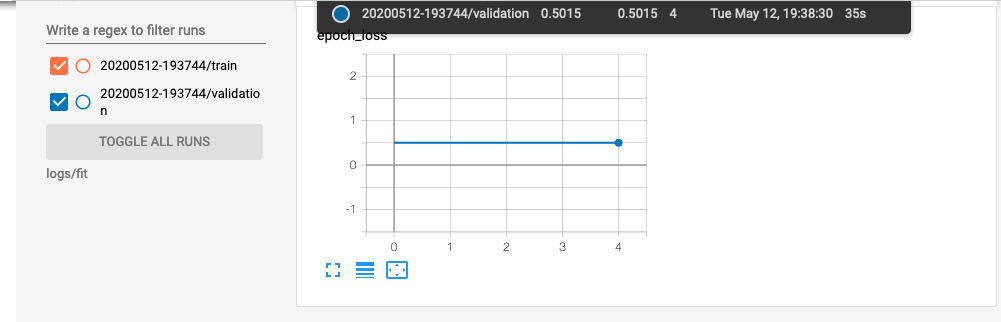


</pre>
<pre>
<b>Model-2</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>
<pre>

In [21]:
# Clear any logs from previous runs
!rm -rf ./logs/ 
Model_1 = CustomModel('RandomUniform', 'SGD', 'relu',5)
%tensorboard --logdir logs/fit

initializer_type RandomUniform <tensorflow.python.ops.init_ops_v2.GlorotUniform object at 0x13a30c240>
optimizer SGD <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x13a30c278>
ModelActivation
activation relu relu
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_15 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 16)                528       
_____________________

Reusing TensorBoard on port 6006 (pid 1078), started 14:08:21 ago. (Use '!kill 1078' to kill it.)

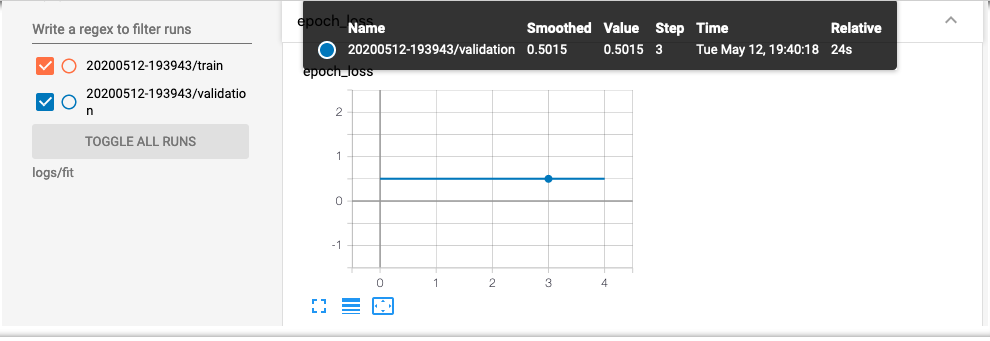

<b>Model-3</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use he_uniform() as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>
<pre>

In [22]:
# Clear any logs from previous runs
!rm -rf ./logs/ 
Model_1 = CustomModel('he_uniform', 'SGD', 'relu',5)
%tensorboard --logdir logs/fit

initializer_type he_uniform <tensorflow.python.ops.init_ops_v2.GlorotUniform object at 0x11416b5f8>
optimizer SGD <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x11416b710>
ModelActivation
activation relu relu
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_22 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
________________________

Reusing TensorBoard on port 6006 (pid 1078), started 14:09:11 ago. (Use '!kill 1078' to kill it.)

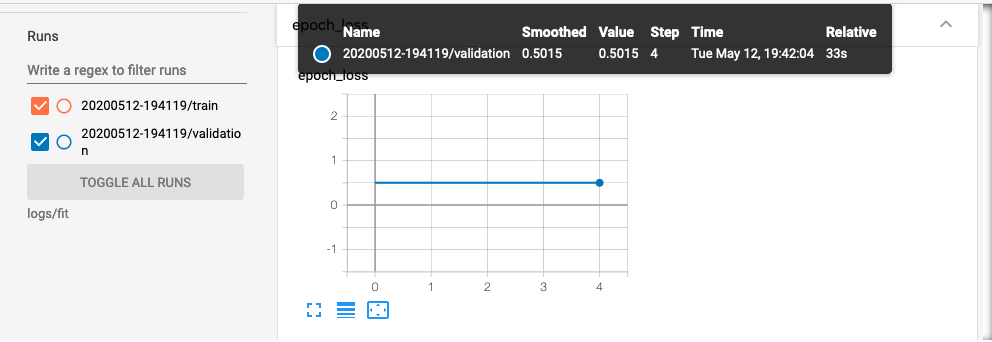



<b>Model-4</b>
<pre>
1. Try with any values to get better accuracy/f1 score.  
</pre>
</pre>

In [30]:
# Clear any logs from previous runs
!rm -rf ./logs/ 
Model_1 = CustomModel('he_uniform', 'Adam', 'relu',5, True)
%tensorboard --logdir logs/fit

initializer_type he_uniform <tensorflow.python.ops.init_ops_v2.GlorotUniform object at 0x13a2b1ba8>
optimizer Adam <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x139a0c080>
ModelActivation
activation relu relu
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_59 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_60 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_61 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_62 (Dense)             (None, 16)                528       
_____________________________

Reusing TensorBoard on port 6006 (pid 1078), started 14:20:04 ago. (Use '!kill 1078' to kill it.)

### experiment -1 

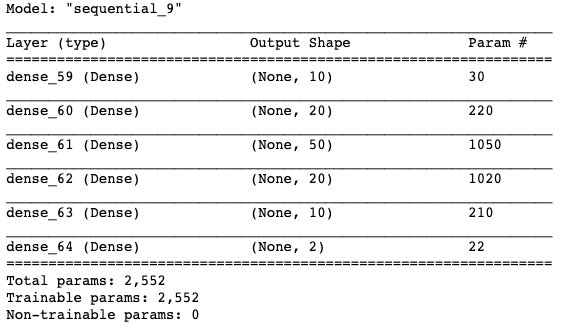

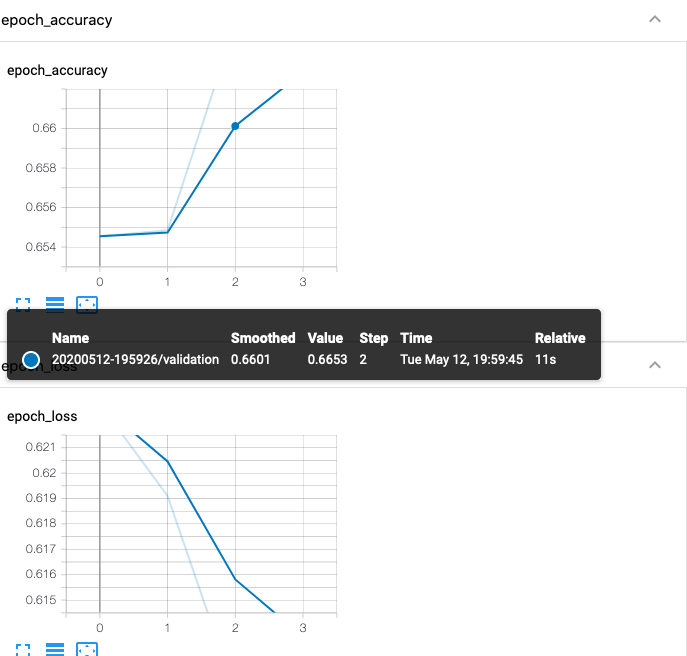

### experimnet  -2 

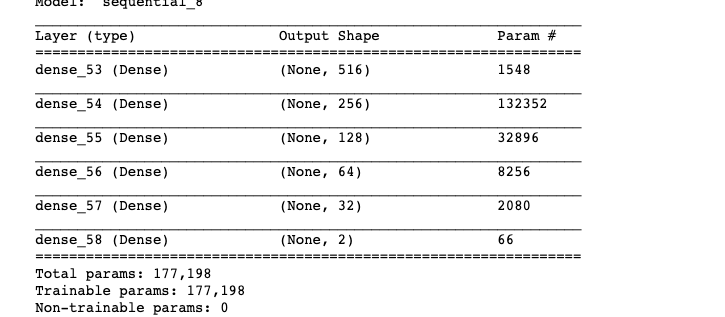

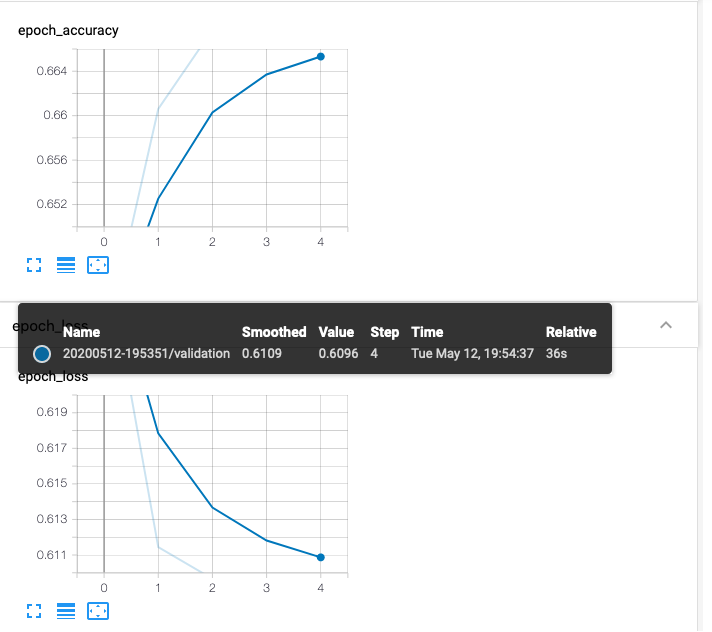

### other experiment same model different params -3

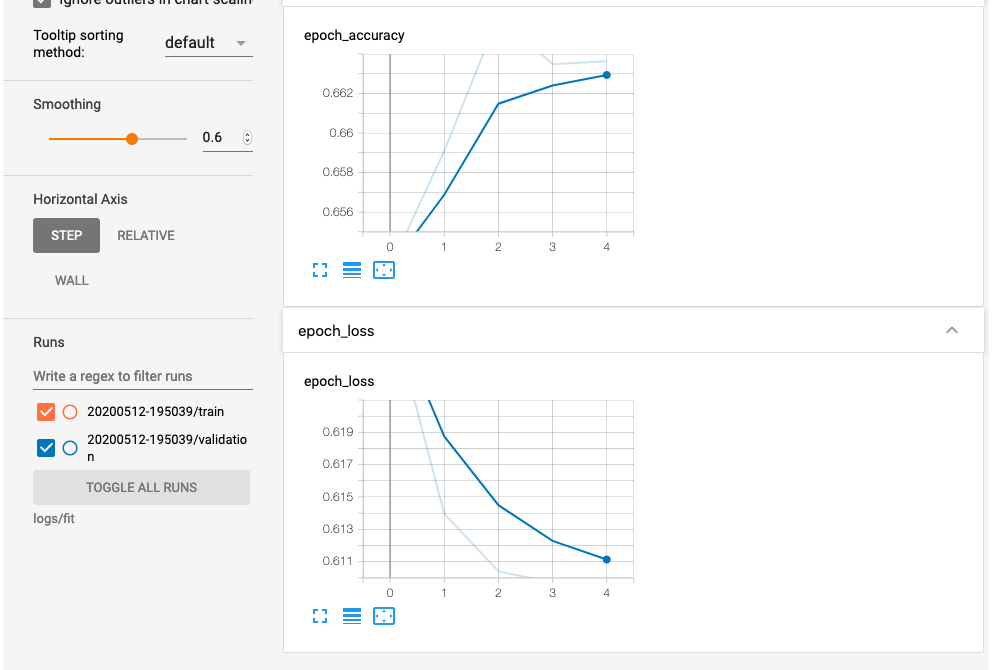

### Observations
    1. Need to know how to build model architecure - sequential models, layersn nuerons in layers and soon.
    2. Weights initalization plays a key role in help model to lear with better accuracy from random to he_uniform 
    3. optimizer helps quicly and clerly learn the features by using sdg, adam ,adadelta and so on, choosing a 
       right optimzer helps accelearate the accuracy 
    4. Loss make model to tell how correctly its learning things differs from type of learning we use like mse ,              sparse_categorical_crossentropy and so, as shown in the above models and graphs we can learn how model is              learning
    5. we can overide the custom callbacks to see our own metrics 
    6. we can start, stop the model training which helps for contious learning 
    7. tensorflow 2.0 version write_grads is removed
    8. With my custom model accuracy is: 67.61%

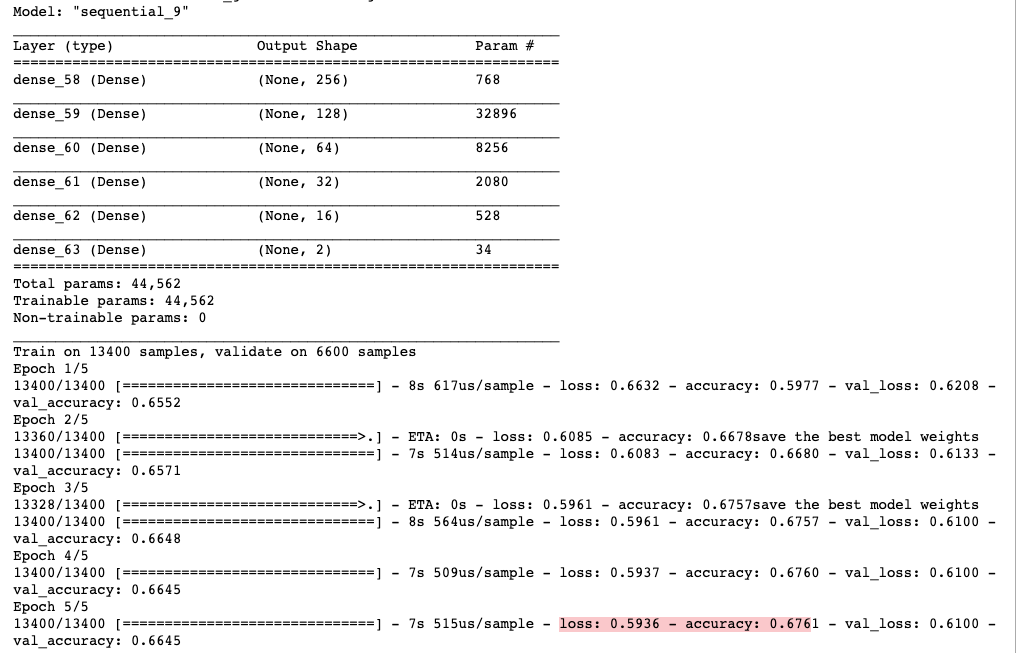